## Uncertainty in Explanations via Model Perturbation (Vision)

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, models
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import cv2

In [2]:
#import sys
#sys.path.append('./xplique/')
from xplique.attributions import (Lime, Saliency, GradientInput, IntegratedGradients, 
                                  SmoothGrad, SquareGrad, VarGrad, Occlusion, Rise,
                                  KernelShap, DeconvNet)

In [3]:
# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
x_train = gray2rgb(x_train)
x_test = gray2rgb(x_test)

In [4]:
# Whether to train a model or load a pretrained one
train_model = False
model_path = './models/cnn_mnist.h5'

In [5]:
if train_model:
    # Build and train a simple CNN
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=2, batch_size=64, validation_split=0.25)
    model.save(model_path)
else:
    model = tf.keras.models.load_model(model_path)
# XAI methods require removal of Softmax
model.layers[-1].activation = tf.keras.activations.linear

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

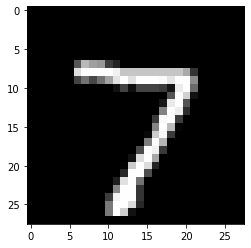

In [8]:
# Explain sample prediction
sample_index = 0
sample_image, sample_label = x_test[sample_index], y_test[sample_index]
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = np.expand_dims(sample_label, axis=0)
sample_image.shape
plt.imshow(sample_image.squeeze());

### Analytical vs empirical (multiple methods, multiple variances)

In [17]:
xai_methods  = {'Saliency': lambda model: Saliency(model),
                'IntegratedGradients': lambda model: IntegratedGradients(model, steps=20, batch_size=1),
                'Lime': lambda model: Lime(model, nb_samples = 20, batch_size=1),
                'SquareGrad': lambda model: SquareGrad(model, nb_samples=20, batch_size=1),
                'GradientInput': lambda model: GradientInput(model),
                'VarGrad': lambda model: VarGrad(model, nb_samples=20, batch_size=1),
                'DeconvNet': lambda model: DeconvNet(model)}

In [13]:
#stds = [0.1, 0.2, 0.3]#, 0.4, 0.5] # std. deviations
stds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
sample_image = sample_image.squeeze()
num_perturbations = 10 # for empirical cov.
dx = 1e-3 # differential for ana. cov.
h = w = sample_image.shape[0] # (28, 28, 3)
m = np.product(np.shape(sample_image)[:-1]) # for simplicity, treat RGB channels as one point/step
n = model.layers[-1].weights[0].shape[0] # number of weights in the final Dense layer (without bias)

In [18]:
# Store results for plotting
results, cov_mats, jacobi_mats = {}, {}, {}

for name, constructor in xai_methods.items():
    print('\n' + name)
    results[name]  = {'analytical': [], 'empirical': []}
    cov_mats[name] = {'analytical': [], 'empirical': []}
    
    # Get explanation in unperturbed model
    explainer = constructor(model) # instantiate explainer with default params
    explanation = explainer(np.expand_dims(sample_image, axis=0), sample_label)[0]
    
    # Precompute Jacobian (stays fixed for every std)
    derivative_e_x = np.zeros((m, n))
    # For every pixel perturbation, we get a new column in the Jacobian
    for i in range(n):
        # Perturb current weight in the model
        perturbed_model = tf.keras.models.load_model(model_path)
        weights, bias = perturbed_model.layers[-1].get_weights()
        weights[i] += dx
        perturbed_model.layers[-1].set_weights([weights, bias])

        # Compute explanations for perturbed model
        explainer = constructor(perturbed_model)
        perturbed_exp = explainer(np.expand_dims(sample_image, axis=0), sample_label)[0]

        # Fill out the corresponding column in the jacobian
        derivative_2d = (perturbed_exp - explanation) / dx
        derivative_e_x[:, i] = derivative_2d.numpy().reshape(m, )
    jacobi_mats[name] = derivative_e_x
    
    for std in stds:
        ### Analytical
        sigma_squared = std ** 2
        covariance_ana = sigma_squared * derivative_e_x @ derivative_e_x.T
        
        # Total variance is the trace of the cov. matrix
        print("Analytical Variance (std = ", std, "):", np.trace(covariance_ana))
        results[name]['analytical'].append(np.trace(covariance_ana))
        cov_mats[name]['analytical'].append(covariance_ana)
        
        ### Empirical
        perturbed_explanations = []
        for _ in range(num_perturbations):
            # Add Gaussian noise to the model weights
            perturbed_model = tf.keras.models.load_model(model_path)
            weights, bias = perturbed_model.layers[-1].get_weights()
            weights += np.random.normal(0, std, weights.shape)
            perturbed_model.layers[-1].set_weights([weights, bias])

            # Generate explanation for perturbed model
            explainer = constructor(perturbed_model)
            perturbed_explanation = explainer.explain(np.expand_dims(sample_image, axis=0), sample_label)[0]
            perturbed_explanations.append(perturbed_explanation.numpy().flatten())
        
        # Stack explanations and compute covariance matrix
        explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
        covariance_emp = np.cov(explanation_matrix, rowvar=False)
        
        print("Empirical Variance (std = ", std, "):", np.trace(covariance_emp))
        results[name]['empirical'].append(np.trace(covariance_emp))
        cov_mats[name]['empirical'].append(covariance_emp)


Saliency
Analytical Variance (std =  1e-06 ): 0.050368033753231775
Empirical Variance (std =  1e-06 ): 2.0209471168417605e-13
Analytical Variance (std =  1e-05 ): 5.036803375323178
Empirical Variance (std =  1e-05 ): 2.0209539340115244e-13
Analytical Variance (std =  0.0001 ): 503.6803375323178
Empirical Variance (std =  0.0001 ): 2.1055124539729372e-13
Analytical Variance (std =  0.001 ): 50368.03375323177
Empirical Variance (std =  0.001 ): 2.01926901276144e-13
Analytical Variance (std =  0.01 ): 5036803.375323177
Empirical Variance (std =  0.01 ): 4.001377976426148e-13
Analytical Variance (std =  0.1 ): 503680337.5323179
Empirical Variance (std =  0.1 ): 1.0260856625380394e-12

IntegratedGradients
Analytical Variance (std =  1e-06 ): 0.008490530343446778
Empirical Variance (std =  1e-06 ): 3.824745722833101e-15
Analytical Variance (std =  1e-05 ): 0.849053034344678
Empirical Variance (std =  1e-05 ): 2.5504457339082728e-15
Analytical Variance (std =  0.0001 ): 84.90530343446781
Emp

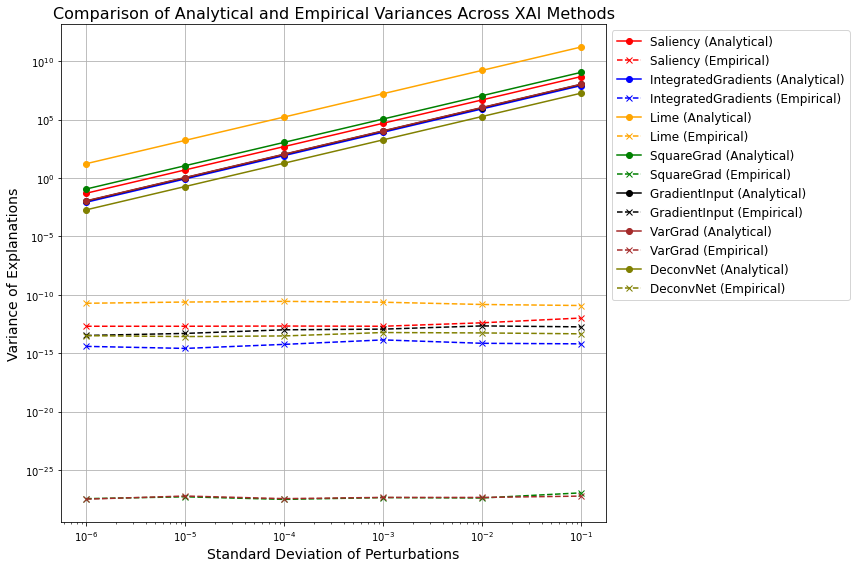

In [19]:
# Sample 0 ('7')
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14); plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14); plt.xscale('log')
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

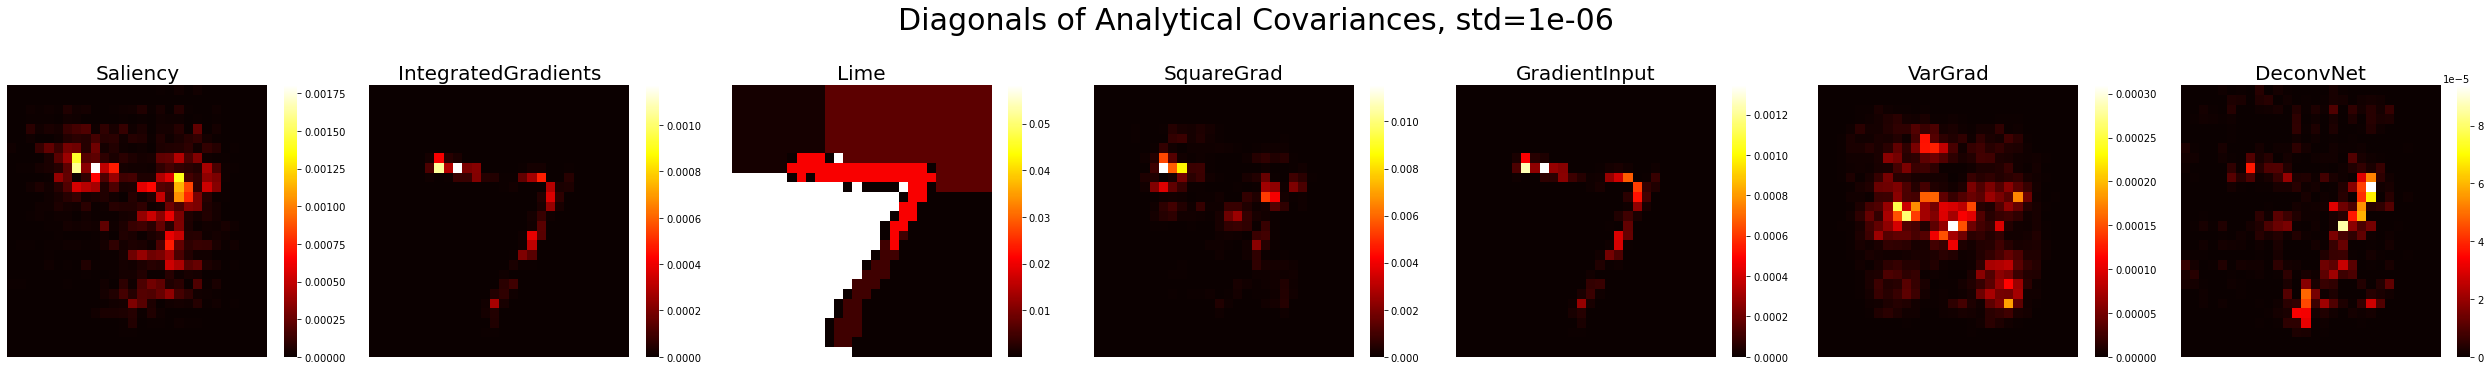

In [21]:
std_ind = 0
fig, axes = plt.subplots(1, len(cov_mats), figsize=(5*len(cov_mats), 5))
fig.suptitle(f'Diagonals of Analytical Covariances, std={stds[std_ind]}', fontsize=30, y=1.02)

for i, (name, cmat) in enumerate(cov_mats.items()):
    ax = axes[i]
    sns.heatmap(np.abs(np.diag(cmat['analytical'][std_ind]).reshape(h,w)), ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
    ax.set_title(f"{name}", fontsize=20)
    ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

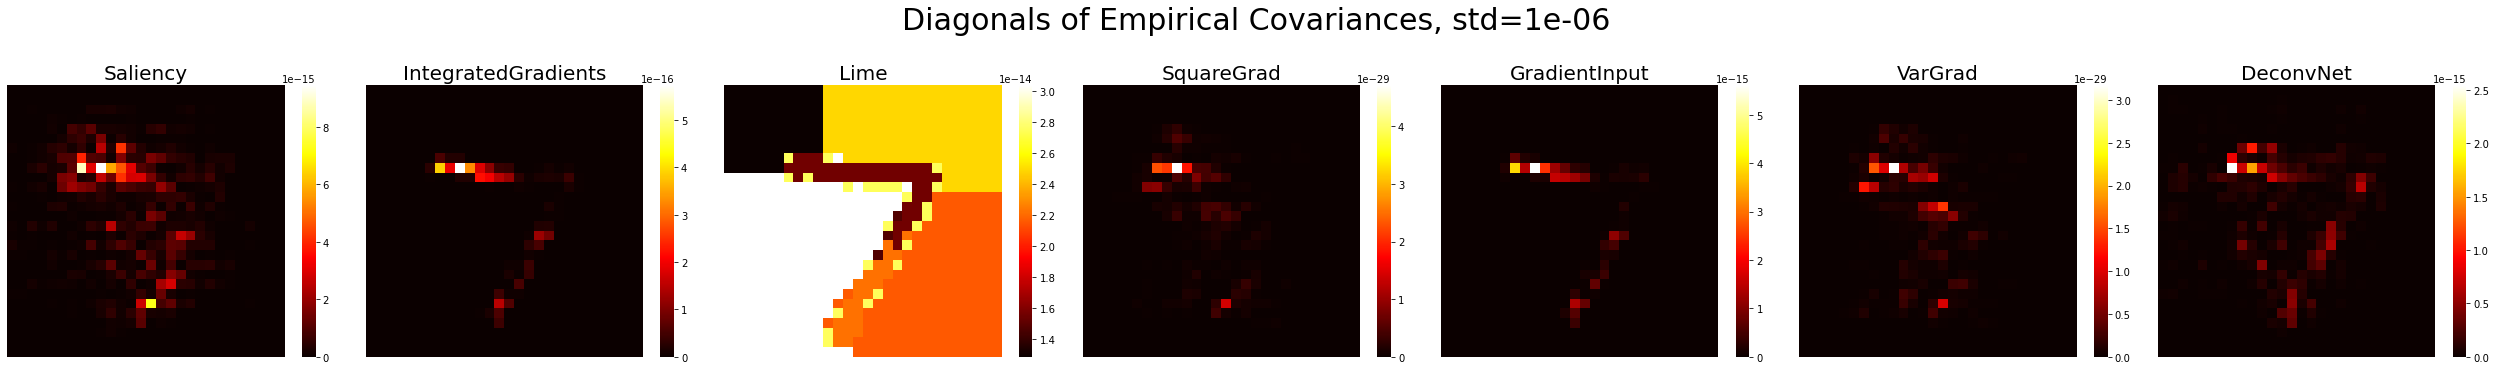

In [22]:
std_ind = 0
fig, axes = plt.subplots(1, len(cov_mats), figsize=(5*len(cov_mats), 5))
fig.suptitle(f'Diagonals of Empirical Covariances, std={stds[std_ind]}', fontsize=30, y=1.02)

for i, (name, cmat) in enumerate(cov_mats.items()):
    ax = axes[i]
    sns.heatmap(np.abs(np.diag(cmat['empirical'][std_ind]).reshape(h,w)), ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
    ax.set_title(f"{name}", fontsize=20)
    ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

In [ ]:
# Create heatmaps for all methods and perturbation stds
# Note: it may take 2 mins to display
def plot_heatmaps(cov_mats, stds):
    num_methods = len(cov_mats)
    num_stds = len(stds)

    fig, axes = plt.subplots(num_methods, num_stds * 2, figsize=(4 * num_stds * 2, 4 * num_methods))
    fig.suptitle('Covariance Matrix Heatmaps (Analytical vs. Empirical)', fontsize=30, y=1.02)

    for i, (name, cov_data) in enumerate(cov_mats.items()):
        for j, std in enumerate(stds):
            # Analytical covariance matrix
            cov_ana = cov_data['analytical'][j]
            ax = axes[i, j * 2]
            sns.heatmap(cov_ana, ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nAna, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

            # Empirical covariance matrix
            cov_emp = cov_data['empirical'][j]
            ax = axes[i, j * 2 + 1]
            sns.heatmap(cov_emp, ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nEmp, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function to generate heatmaps
plot_heatmaps(cov_mats, stds)